In [18]:
# visualising the result of applying filters
# to input
# i.e. visualising feature maps
# tutorial: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [19]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal, scipy.io.wavfile
import skimage.morphology, skimage.transform, skimage.feature, scipy.stats

%matplotlib inline
import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (18.0, 10.0)

#standard utilities
def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)
    
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

def load_gray(f):
    return skimage.color.rgb2gray(load_and_normalise(f))

def reshape(img):
    return np.reshape(img, (image_width, image_height))

def plot_results(input_imgs, output_imgs):
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, 6):
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(reshape(input_imgs[i+10]), cmap='gist_yarg')
        ax.axis('off')

    for i in range(1, 6):
        ax = fig.add_subplot(2, 5, i)
        plt.imshow(reshape(output_imgs[i+10]), cmap='gist_yarg')
        ax.axis('off') 

In [123]:
def filenames_to_labels(filenames, folder):
    labels = []
    for file in filenames:
        file = file.split("(")[0].lstrip(folder)
        label = "".join(_ for _ in file if _ in "123456789")
        labels.append(int(label))
    return labels

In [124]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.util import crop
from PIL import Image

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
filenames = sorted(filenames)[1:]

image_width = 200
image_height = 200

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)
raw_labels = []

i = 0
for file in filenames:
    try:
        image = load_and_normalise(file)
        to_crop = (image.shape[0]-image_width)/2
        image_resized = crop(image, (to_crop, to_crop))
        dataset[i] = image_resized
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

labels = filenames_to_labels(filenames, folder)

In [125]:
labels

[1,
 1,
 11,
 11,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 2,
 2,
 21,
 21,
 22,
 22,
 23,
 23,
 24,
 24,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 1,
 1,
 11,
 11,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 2,
 2,
 21,
 21,
 22,
 22,
 23,
 23,
 24,
 24,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 1,
 1,
 11,
 11,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 2,
 2,
 21,
 21,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 1,
 1,
 11,
 11,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 2,
 2,
 21,
 21,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 1,
 1,
 11,
 11,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 2,
 2,
 21,
 21,
 3,
 3,
 4,
 4,
 5,
 5,
 6,
 6,
 7,
 7,
 8,
 8,
 9,
 9,
 1,
 1,
 11,
 11,
 13,
 13,
 14,
 14,
 15,
 15,
 16,
 16,
 17,
 17,
 18,
 18,
 19,
 19,
 2,
 2,
 21,
 21,
 3,
 3,
 4,
 4,
 5,
 5,


In [120]:
def even_round(num):
    return round(num/2.)*2

def dataset_split(dataset, labels, test_size=0.2):
    test_size = even_round(len(dataset)*test_size)
    x_train, x_test = dataset[:-test_size], dataset[-test_size:]
    y_train, y_test = labels[:-test_size], labels[-test_size:]
    return x_train, x_test, y_train, y_test

# x_train and x_test need to be kept in same order 
# as we need to do pairwise overlap calculations
x_train, x_test, y_train, y_test = dataset_split(dataset, labels, test_size=0.2)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

In [22]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [23]:
model = Model(input_img, decoded)
# encoder = Model(input_img, encoded)

In [25]:
#encoded_imgs = encoder.predict(x_test)
decoded_imgs = model.predict(x_test)

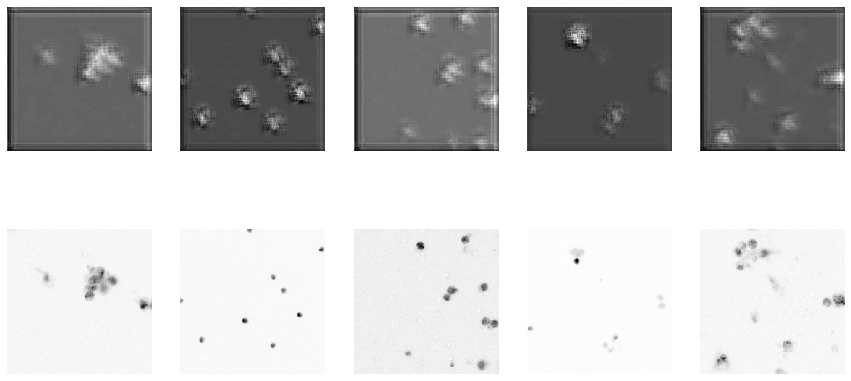

In [26]:
plot_results(x_test, decoded_imgs)

In [92]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=6, learning_rate=11)
clusters = tsne.fit_transform(overlaps)

1
1
11
11
13
13
14
14
15
15
16
16
17
17
18
18
19
19
2
2
21
21
22
22
23
23
24
24
3
3
4
4
5
5
6
6
7
7
8
8
9
9
1
1
11
11
13
13
14
14
15
15
16
16
17
17
18
18
19
19
2
2
21
21
22
22
23
23
24
24
3
3
4
4
5
5
6
6
7
7
8
8
9
9
1
1
11
11
13
13
14
14
15
15
16
16
17
17
18
18
19
19
2
2
21
21
3
3
4
4
5
5
6
6
7
7
8
8
9
9
1
1
11
11
13
13
14
14
15
15
16
16
17
17
18
18
19
19
2
2
21
21
3
3
4
4
5
5
6
6
7
7
8
8
9
9
1
1
11
11
13
13
14
14
15
15
16
16
17
17
18
18
19
19
2
2
21
21
3
3
4
4
5
5
6
6
7
7
8
8
9
9
1
1
11
11
13
13
14
14
15
15
16
16
17
17
18
18
19
19
2
2
21
21
3
3
4
4
5
5
6
6
7
7
8
8
9
9
1
1
11
11
13
13
14
{'1': 'k', '11': 'k', '13': 'k', '14': 'k', '15': 'k', '16': 'k', '17': 'k', '18': 'k', '19': 'k', '2': 'k', '21': 'k', '22': 'k', '23': 'k', '24': 'k', '3': 'k', '4': 'k', '5': 'k', '6': 'k', '7': 'k', '8': 'k', '9': 'k'}


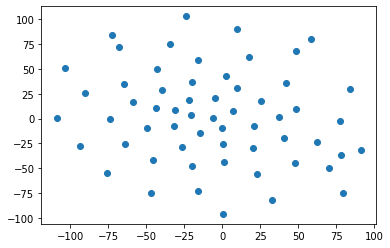

In [138]:
plt.figure()
lmap = label_to_colourmap(y_overlap)
label_color = [lmap[l] for l in y_overlap]
plt.scatter(clusters[:,0], clusters[:,1], cmap=label_color)
print(lmap)

In [137]:
# calculate overlap between t-cell and dendritic cell
# according to stimulation
# incl. compute labels for each 

def calculate_overlap(imgs, labels):
    idx, y = 0, 0
    overlaps = np.ndarray(shape=(len(imgs)//2, image_width*image_height), dtype=np.float32)
    overlap_labels = []
    while idx < len(imgs)-1:
        tcell = imgs[idx]
        dcell = imgs[idx+1]
        o = reshape(np.abs(dcell-tcell))
        overlaps[y] = o.ravel()
        overlap_labels.append(labels[y])
        idx += 2
        y += 1
    return overlaps, overlap_labels

x_overlap, y_overlap = calculate_overlap(x_train, y_train)

def label_to_colourmap(labels):
    lmap = {}
    for label in labels:
        print(label)
        if label in [1, 2, 3, 4, 5, 6, 7, 8, 12, 24]:
            lmap[label] = 'b'
        elif label in [9, 10, 11, 13, 14, 15, 23]:
            lmap[label] = "y"
        elif label in [16, 17, 18, 19, 20, 21, 22]:
            lmap[label] = 'r'
        else:
            lmap[label] = 'k'
    return lmap

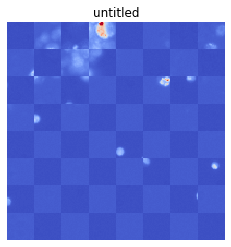

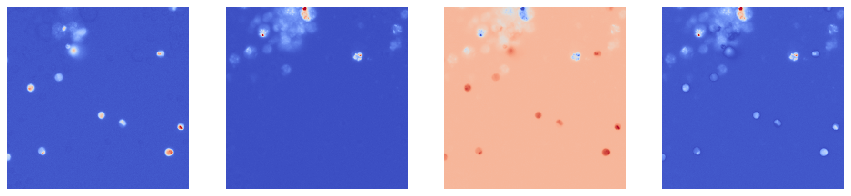

In [17]:
from skimage.util import compare_images

checkerboard = compare_images(reshape(tcell), reshape(dcell), method='checkerboard')
show_image(checkerboard, cmap="coolwarm")

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(1, 4, 1)
ax.axis('off') 
plt.imshow(reshape(tcell), cmap="coolwarm")

ax = fig.add_subplot(1, 4, 2)
ax.axis('off') 
plt.imshow(reshape(dcell), cmap="coolwarm")

ax = fig.add_subplot(1, 4, 3)
ax.axis('off') 
plt.imshow(reshape(tcell-dcell), cmap="coolwarm")
ax = fig.add_subplot(1, 4, 4)
ax.axis('off') 
plt.imshow(reshape(np.abs(dcell-tcell)), cmap="coolwarm")


ValueError: cannot reshape array of size 18 into shape (200,200)

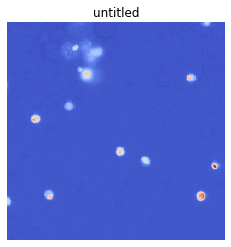

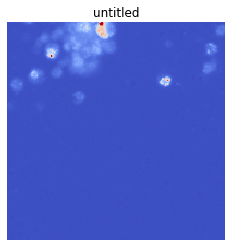

In [12]:
tcell = x_train[0]
dcell = x_train[1]
idx = np.where(tcell==dcell)
show_image(reshape(tcell), cmap="coolwarm")
show_image(reshape(dcell), cmap="coolwarm")
show_image(reshape(idx), cmap='coolwarm')
tcell[np.where(tcell==dcell)]
#show_image(tcell[idx])

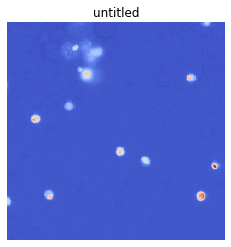

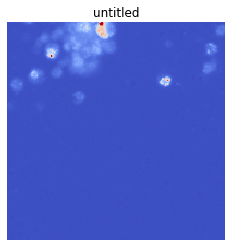

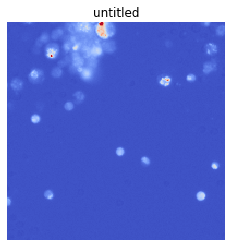

In [316]:
idx = 0
while idx < 2:
    tcell = x_train[idx]
    dcell = x_train[idx+1]
    show_image(reshape(tcell), cmap="coolwarm")
    show_image(reshape(dcell), cmap="coolwarm")
    show_image(reshape(0.5*(dcell+tcell)), cmap="coolwarm")
    idx += 2

In [ ]:
idx = 23
sample = np.expand_dims(x_test[idx], axis=0)
d1 = np.reshape(decoded_imgs[idx], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))
compressed = np.reshape(encoded_imgs[idx],(encoder.output.shape[1], encoder.output.shape[2]*encoder.output.shape[3]))
show_image(before, 'original', cmap='gist_yarg')
show_image(compressed, "compressed representation", cmap="gist_yarg")
show_image(d1, 'decoded', cmap='gist_yarg')

In [73]:
compressed.shape

(25, 1600)

In [ ]:
sample.shape

In [ ]:
encoded_imgs[idx].shape

In [ ]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))filters, biases = model.layers[1].get_weights()

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
x_train[12].shape

In [ ]:
sample = np.expand_dims(x_train[44], axis=0)

In [ ]:
sample.shape

In [ ]:
feature_maps = feature_model.predict(sample)

In [ ]:
feature_maps.shape

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

In [ ]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

In [ ]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1